In [21]:
import tweepy
from dotenv import load_dotenv
import os
import pandas as pd
import re
load_dotenv()
from pathlib import Path
from nltk.corpus import reuters, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud

In [92]:
tweepyKey = os.getenv("tweepyKey")
tweepyClient = tweepy.Client(tweepyKey)
# tweepyClient = tweepy.Client()

startDate = '2022-05-29'
startDate = '2022-05-30'

In [3]:
def basic_count(query):
    count_df=pd.DataFrame(columns=['time', 'count'])
    response = tweepyClient.get_recent_tweets_count(query, granularity="hour")
    for count in response.data:
        data={'time':count['end'], 'count':count['tweet_count']}
        count_df=count_df.append(data, ignore_index=True)
    return count_df

In [4]:
# import nltk
# nltk.download('vader_lexicon')
# from textblob import TextBlob as tb
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-06-02 19:51:24,676 loading file /Users/guruprasadmulay/.flair/models/sentiment-en-mix-distillbert_4.pt


In [13]:
# def clean_tweet(resp):
#     tweet=str(resp).lower()
#     tweet=re.sub(r"http\S+", '',tweet)
#     tweet=re.sub(r"www.\S+",'',tweet)
#     tweet=re.sub("[^A-Za-z0-9]"," ",tweet)
#     tweet=tweet.split()
#     tweet=' '.join(word for word in tweet)
#     return tweet

# TODO save tweets in file
from pathlib import Path
def tweets(start_time, end_time, iterations, query, useStoredData = False):
    # use dummy data reduce api calls
    if useStoredData:
        file_path = Path("Resources/dummyData.csv")
        return pd.read_csv(file_path)

    datelist = pd.date_range(start_time, end_time, periods=iterations).tolist()
    tweets=[]
    date=[]
    prob=[]
    sentim=[]
    counter = 0
    for time in datelist:
        if counter > 1:
            #Fetching Tweets
            response = tweepyClient.search_recent_tweets(
                query,
                max_results=100,
                start_time=start,
                end_time=time,
                tweet_fields=["created_at"])
    
            if type(response.data) != type(None):
                #Data Cleaning
                for resp in response.data:
                    # tweet = clean_tweet(resp)
                    tweet = str(resp)
                    if len(tweet) > 0:
                        # Sentiment analysis
                        # sentence = flair.data.Sentence(tweet)
                        # sentiment_model.predict(sentence)
                        tweets.append(tweet)
                        date.append(resp.created_at)
                        # prob.append(sentence.labels[0].score)
                        # sentim.append(sentence.labels[0].value)
        start=time
        counter = counter + 1

        # if counter == 3:
        #     break
        
    tweet_df=pd.DataFrame({'time':date, 'tweet':tweets,
    #  'probability':prob, 'sentiment':sentim
     })
    tweet_df=tweet_df.sort_values(by='time', ascending=True).set_index('time')
    tweet_df.to_csv('Resources/dummyData.csv')
    return tweet_df

In [104]:
BTCTweets=tweets(startDate, endDate, 10, 'btc OR bitcoin OR crypto -is:retweet lang:en', useStoredData=False)
BTCTweets.head()

Unauthorized: 401 Unauthorized
Unauthorized

In [25]:
#cleaning
def cleaning(df):
    cleaned_tweets=[]
    for word in df['tweet']:
        #convert to string
        tw=str(word)
        #remove web links
        tw=re.sub(r"http\S+", "",tw)
        tw=re.sub(r"www\S+","",tw)
        #Remove mentions
        tw=re.sub(r"@\S+", "", tw)
        #remove non alphabetic characters
        tw=re.sub("[^A-Za-z0-9]"," ",tw)
        #remove rt
        tw=re.sub(r"RT","",tw)
        cleaned_tweets.append(tw.lower())
    df['cleaned_tweets']=cleaned_tweets
    return

#tokenizer 
def tokenizer(df):
    sw = set(stopwords.words('english'))
    token_tweets=[]
    for tweet in df['cleaned_tweets']:
        words = word_tokenize(tweet)
        lem = [lemmatizer.lemmatize(word) for word in words]
        output=[word for word in lem if word not in sw]
        token_tweets.append(output)
    df['token_tweets']=token_tweets
    return

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def sentiment(df):
    compound=[]
    pos=[]
    neu=[]
    neg=[]
    for tweet in df['cleaned_tweets']:
        sentiment=analyzer.polarity_scores(tweet)
        compound.append(sentiment['compound'])
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
    df['compound']=compound
    df['pos']=pos
    df['neu']=neu
    df['neg']=neg
    return
import matplotlib.pyplot as plt

def wc(df):
    biglist=[]
    for tweets in df['token_tweets']:
        biglist=biglist+tweets
    bigstring=' '.join(biglist)
    wc=WordCloud().generate(bigstring)
    return plt.imshow(wc)


In [24]:
cleaning(BTCTweets)
#  TODO include word embedding instead of tokenizer
tokenizer(BTCTweets)
sentiment(BTCTweets)



,tweet,cleaned_tweets,token_tweets,compound,pos,neu,neg
time,,,,,,,
2022-05-29 05:19:37+00:00,RT @DMM_Bitcoin: ／\n毎日参加！その場で当たる！\n🎉 #フォローRTキャ...,400 500 ...,"[400, 500, url]",0.0000,0.000,1.000,0.0
2022-05-29 05:19:37+00:00,@1goonrich We're never getting rekt\nOne of th...,we re never getting rekt one of the most amaz...,"[never, getting, rekt, one, amazing, fast, ris...",0.9258,0.317,0.683,0.0
2022-05-29 05:19:37+00:00,RT @airdropinspect: New airdrop: CloudChat (CC...,new airdrop cloudchat cc total reward 1 ...,"[new, airdrop, cloudchat, cc, total, reward, 1...",0.8225,0.381,0.619,0.0
2022-05-29 05:19:37+00:00,RT @RecessionCoin: 24 HOURS UNTIL PRESALE!! Ma...,24 hours until presale make sure to join o...,"[24, hour, presale, make, sure, join, telegram...",0.5423,0.191,0.809,0.0
2022-05-29 05:19:37+00:00,RT @DMM_Bitcoin: ／\n毎日参加！その場で当たる！\n🎉 #フォローRTキャ...,400 500 ...,"[400, 500, url]",0.0000,0.000,1.000,0.0


In [98]:
BTCTweets.head(20)

,tweet,cleaned_tweets,token_tweets,compound,pos,neu,neg
time,,,,,,,
2022-05-29 05:19:37+00:00,RT @DMM_Bitcoin: ／\n毎日参加！その場で当たる！\n🎉 #フォローRTキャ...,400 500 ...,"[400, 500, url]",0.0000,0.000,1.000,0.000
2022-05-29 05:19:37+00:00,@1goonrich We're never getting rekt\nOne of th...,we re never getting rekt one of the most amaz...,"[never, getting, rekt, one, amazing, fast, ris...",0.9258,0.317,0.683,0.000
2022-05-29 05:19:37+00:00,RT @airdropinspect: New airdrop: CloudChat (CC...,new airdrop cloudchat cc total reward 1 ...,"[new, airdrop, cloudchat, cc, total, reward, 1...",0.8225,0.381,0.619,0.000
2022-05-29 05:19:37+00:00,RT @RecessionCoin: 24 HOURS UNTIL PRESALE!! Ma...,24 hours until presale make sure to join o...,"[24, hour, presale, make, sure, join, telegram...",0.5423,0.191,0.809,0.000
2022-05-29 05:19:37+00:00,RT @DMM_Bitcoin: ／\n毎日参加！その場で当たる！\n🎉 #フォローRTキャ...,400 500 ...,"[400, 500, url]",0.0000,0.000,1.000,0.000
2022-05-29 05:19:38+00:00,RT @DMM_Bitcoin: ／\n毎日参加！その場で当たる！\n🎉 #フォローRTキャ...,400 500 ...,"[400, 500, url]",0.0000,0.000,1.000,0.000
2022-05-29 05:19:38+00:00,@Michael93605117 Next #BSC #Metaverse gem taki...,next bsc metaverse gem taking the crypto sp...,"[next, bsc, metaverse, gem, taking, crypto, sp...",0.0000,0.000,1.000,0.000
2022-05-29 05:19:39+00:00,@LithiumVentures @LunaFi_Project Fantastic pro...,fantastic project with great potential the ...,"[fantastic, project, great, potential, team, d...",0.9538,0.467,0.482,0.051
2022-05-29 05:19:39+00:00,@ashwsbreal BTC 11k USD olacak,btc 11k usd olacak,"[btc, 11k, usd, olacak]",0.0000,0.000,1.000,0.000


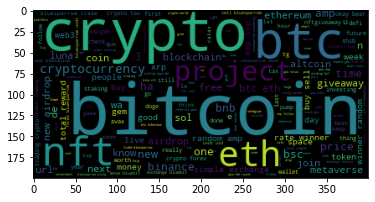

In [26]:
wc(BTCTweets)

In [52]:
# remov na compounds
BTCTweetsTemp = BTCTweets[BTCTweets['compound'] != 0]
BTCTweetsTemp = BTCTweetsTemp[['compound']]
# BTCTweetsTemp[BTCTweetsTemp.index == '2022-05-29 05:19:37']

In [ ]:
BTCTweets[['pos', 'neu', 'neg']].sum()

In [84]:

# BTCTweetsTemp2=BTCTweetsTemp
# convert date format to hour & minutes
# BTCTweetsTemp2['date'] = pd.to_datetime(BTCTweetsTemp2.index.strftime("%Y-%m-%d %-H:%M"))

# get avg compound score for minutes interval
# BTCTweetsTemp1 = BTCTweetsTemp2 \
# .groupby(by=[ BTCTweetsTemp2.date ]).mean()
BTCTweetsTemp1 = BTCTweets[['compound']].groupby(pd.Grouper(freq='T')).mean()
BTCTweetsCount = BTCTweets[['compound']].groupby(pd.Grouper(freq='T')).mean()


BTCTweetsTemp1.dropna()

,compound
time,
2022-05-29 05:19:00+00:00,0.277966
2022-05-29 07:59:00+00:00,0.167818
2022-05-29 10:39:00+00:00,0.172807
2022-05-29 13:19:00+00:00,0.276262
2022-05-29 15:59:00+00:00,0.290651
2022-05-29 18:39:00+00:00,0.257277
2022-05-29 21:19:00+00:00,0.266066
2022-05-29 23:59:00+00:00,0.222387


In [91]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
tradesData = pdr.get_data_yahoo("BTC-USD", start=startDate, end=endDate, interval="1m")

tradesData['actual_returns'] = tradesData['Close'].pct_change()
tradesData.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,actual_returns
Datetime,,,,,,,
2022-05-29 13:55:00+00:00,29329.970703,29329.970703,29329.970703,29329.970703,29329.970703,0,-0.000178
2022-05-29 13:56:00+00:00,29323.894531,29323.894531,29323.894531,29323.894531,29323.894531,1519616,-0.000207
2022-05-29 13:57:00+00:00,29319.662109,29319.662109,29319.662109,29319.662109,29319.662109,1312768,-0.000144
2022-05-29 13:58:00+00:00,29313.562500,29313.562500,29313.562500,29313.562500,29313.562500,21667840,-0.000208
2022-05-29 13:59:00+00:00,29314.597656,29314.597656,29314.597656,29314.597656,29314.597656,1284096,0.000035


<AxesSubplot:xlabel='Datetime'>

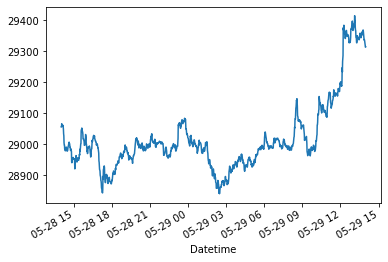

In [93]:
tradesData['Close'].plot()

In [103]:
merged_pdf = pd.concat([BTCTweetsTemp1, tradesData[['actual_returns']]], join="inner", axis=1)
merged_pdf = merged_pdf.dropna()
merged_pdf['target_return'] = merged_pdf['actual_returns'].shift(-1)
merged_pdf

,compound,actual_returns,target_return
2022-05-29 05:19:00+00:00,0.277966,0.000203,-0.000027
2022-05-29 07:59:00+00:00,0.167818,-0.000027,-0.000141
2022-05-29 10:39:00+00:00,0.172807,-0.000141,0.000569
2022-05-29 13:19:00+00:00,0.276262,0.000569,NaN


In [ ]:
# todo shift returns
# unsifted returns are positive - Buy